## Verifiable factual claims detection: 
Given a tweet, predict whether it contains a verifiable factual claim. This is a binary task with two labels: Yes and No. This is a classification task

### About the Dataset
The dataset contains the basic information on "Fighting the COVID-19 Infodemic and Fake News Detection".

### Abstract of the Notebook
For this subtask, we built, tuned and evaluated models by using 2 feature extraction methods - CountVectorization and TF-IDF and 3 ML Algorithms - Bernoulli, LinearSVC and Logistic Regression.

### Importing Dependencies

In [ ]:
import re
import numpy as np
import pandas as pd

# nltk
from nltk.stem import WordNetLemmatizer

#sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_score

#plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
lemmatizer = WordNetLemmatizer()

### The Dataset

In [ ]:
df_train = pd.read_table("data/CT22_english_1B_claim_train.tsv")
df_test=pd.read_table("data/CT22_english_1B_claim_dev_test.tsv")

In [ ]:
print("train size: ", df_train.shape)
print("test size: ", df_test.shape)

train size:  (3324, 5)
test size:  (911, 5)


In [ ]:
df_train.head(10)

,topic,tweet_id,tweet_url,tweet_text,class_label
0,COVID-19,1.359351e+18,http://twitter.com/user/status/135935094335617...,"India's gift of 100,000 COVID-19 vaccines arri...",1
1,COVID-19,1.350166e+18,http://twitter.com/user/status/135016568806166...,Here’s what I’m doing while I wait my turn for...,0
2,COVID-19,1.369750e+18,http://twitter.com/user/status/136974953915491...,"This afternoon, I’m hosting an event with the ...",0
3,COVID-19,1.350165e+18,http://twitter.com/user/status/135016499568693...,"Help shops like mine stay open. Mask up, avoid...",0
4,COVID-19,1.370008e+18,http://twitter.com/user/status/137000807648978...,As part of the ongoing nationwide vaccination ...,1
5,COVID-19,1.367727e+18,http://twitter.com/user/status/136772673004420...,"Pleased to receive 50,000 doses of Covid-19 va...",1
6,COVID-19,1.365685e+18,http://twitter.com/user/status/136568467320508...,Information on Astrazeneca and SinoVac COVID-1...,0
7,COVID-19,1.369888e+18,http://twitter.com/user/status/136988848341471...,Four former presidents have banded together fo...,1
8,COVID-19,1.370004e+18,http://twitter.com/user/status/137000387945529...,America has always been at its best when we ar...,0
9,COVID-19,1.354166e+18,http://twitter.com/user/status/135416637152604...,There is so much misinformation and fear-monge...,0


In [ ]:
tweet_ex = df_train['tweet_text'][6]
tweet_ex

'Information on Astrazeneca and SinoVac COVID-19 Vaccines from UP-PGH COVID-19 Groups 💉💉💉 https://t.co/wpqUkoqjxW'

In [ ]:
tweet_ex.encode('unicode_escape')

b'Information on Astrazeneca and SinoVac COVID-19 Vaccines from UP-PGH COVID-19 Groups \\U0001f489\\U0001f489\\U0001f489 https://t.co/wpqUkoqjxW'

In [ ]:
emoji_pattern = re.compile("[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF"
                           "\U00002500-\U00002BEF\U00002702-\U000027B0\U00002702-\U000027B0\U000024C2-\U0001F251"
                           "\U0001f926-\U0001f937\U0001F1F2-\U0001F1F4\U0001F1E6-\U0001F1FF\u2640-\u2642\u2600-\u2B55"
                           "\u200d\u23cf\u23e9\u231a\u3030]+", flags=re.UNICODE)

In [ ]:
tweet_ex = re.sub(emoji_pattern, '', tweet_ex)
tweet_ex

'Information on Astrazeneca and SinoVac COVID-19 Vaccines from UP-PGH COVID-19 Groups  https://t.co/wpqUkoqjxW'

In [ ]:
tweet_ex = re.sub(r'http\S+', '', tweet_ex)
tweet_ex

'Information on Astrazeneca and SinoVac COVID-19 Vaccines from UP-PGH COVID-19 Groups  '

### Text Pre-Processing

In [ ]:
# Transform words to their root form (called lemma)
def lemmatize_tweet(tweet):
    words = tweet.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

In [ ]:
df_train['tweet_text'][0]

"India's gift of 100,000 COVID-19 vaccines arrived Barbados earlier today. This was a very special moment for all Barbadians and I want to thank Prime Minister Modi for his quick, decisive, and magnanimous action in allowing us to be the beneficiary of these vaccines. https://t.co/cSCb40c2mt"

In [ ]:
lemmatize_tweet(df_train['tweet_text'][0])

"India's gift of 100,000 COVID-19 vaccine arrived Barbados earlier today. This wa a very special moment for all Barbadians and I want to thank Prime Minister Modi for his quick, decisive, and magnanimous action in allowing u to be the beneficiary of these vaccines. https://t.co/cSCb40c2mt"

<i>No countable effect of lemmatization</i>

In [ ]:
def pre_process(tweet):
    
    # Remove Emojis
    emojiPattern = re.compile("[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF"
                           "\U00002500-\U00002BEF\U00002702-\U000027B0\U00002702-\U000027B0\U000024C2-\U0001F251"
                           "\U0001f926-\U0001f937\U0001F1F2-\U0001F1F4\U0001F1E6-\U0001F1FF\u2640-\u2642\u2600-\u2B55"
                           "\u200d\u23cf\u23e9\u231a\u3030]+", flags=re.UNICODE)
    tweet = re.sub(emoji_pattern, '', tweet)
    
    # Remove URLs
    urlPattern = r"((http[s]?://)[^\s]*|(www\.)[^\s]*)"
    tweet = re.sub(urlPattern, '', tweet)
    
    # Remove User Mentions
    userPattern = r"@[^\s]+"
    tweet = re.sub(userPattern,'',tweet)
    
    # Lower case
    tweet = tweet.lower()
    
    # Remove sequence pattern
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
    
    
    
    # Lemmatize tweets
    tweet = lemmatize_tweet(tweet)
        
    return tweet

In [ ]:
x_train = df_train['tweet_text'].apply(pre_process)
y_train = df_train['class_label']

In [ ]:
x_test = df_test['tweet_text'].apply(pre_process)
y_test = df_test['class_label']

In [ ]:
x_train.head(10)

0    india's gift of 100,00 covid-19 vaccine arrive...
1    here’s what i’m doing while i wait my turn for...
2    this afternoon, i’m hosting an event with the ...
3    help shop like mine stay open. mask up, avoid ...
4    a part of the ongoing nationwide vaccination r...
5    pleased to receive 50,00 dos of covid-19 vacci...
6    information on astrazeneca and sinovac covid-1...
7    four former president have banded together for...
8    america ha always been at it best when we are ...
9    there is so much misinformation and fear-monge...
Name: tweet_text, dtype: object

In [ ]:
y_train.value_counts()

1    2122
0    1202
Name: class_label, dtype: int64

<i> We can see here, that there is class imbalance in training data. This can lead to biased model performance and needs to be handled. We tried Upsampling and Downsampling on the training data, but it was leading to poor performance due to overfitting. So we will be handling it by tuning the class-weight hyperparameter while fitting the models.<i>

### Feature Extraction (Using CountVectorizer)

In [ ]:
# Create Vocablury (can use max_df for tuning)
vectorizer = CountVectorizer(max_df=0.95)
vectorizer.fit(x_train)
print(f'Vectoriser fitted.')
print("Vocabulary: ", len(vectorizer.vocabulary_), " words")

Vectoriser fitted.
Vocabulary:  10508  words


In [ ]:
# Transform training and testing data using the vectorizer
x_train_vector = vectorizer.fit_transform(x_train) 
x_test_vector = vectorizer.transform(x_test)
print(f'Data Transformed.')

Data Transformed.


### Function for Model Evaluation

In [ ]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(x_test_vector)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### Evaluating Different Models

### Linear SVC model

              precision    recall  f1-score   support

           0       0.61      0.71      0.66       337
           1       0.81      0.73      0.77       574

    accuracy                           0.73       911
   macro avg       0.71      0.72      0.71       911
weighted avg       0.74      0.73      0.73       911



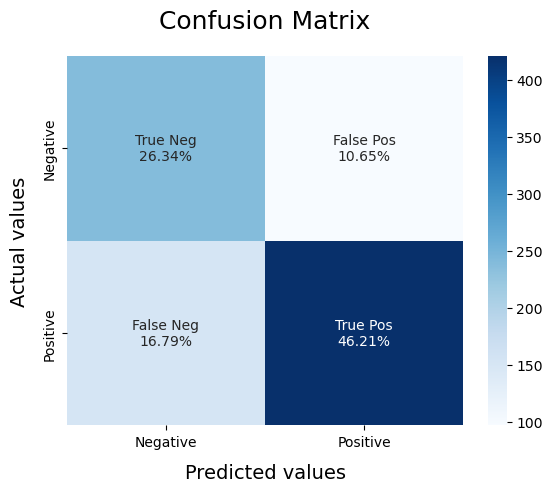

In [ ]:
classifier = LinearSVC(C=0.05, class_weight="balanced", max_iter=1000)
classifier.fit(x_train_vector, y_train)
model_Evaluate(classifier)

              precision    recall  f1-score   support

           0       0.59      0.79      0.67       337
           1       0.85      0.68      0.75       574

    accuracy                           0.72       911
   macro avg       0.72      0.73      0.71       911
weighted avg       0.75      0.72      0.72       911



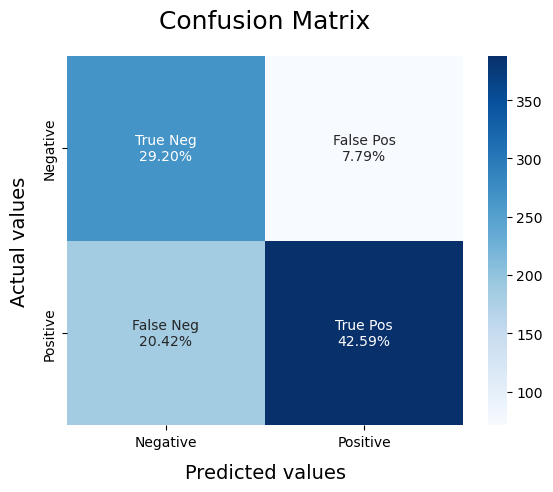

In [ ]:
classifier = LinearSVC(C=0.05, class_weight={0: 1.76539101, 1:0.56644675}, max_iter=1000)
classifier.fit(x_train_vector, y_train)
model_Evaluate(classifier)

### Bernoulli model

              precision    recall  f1-score   support

           0       0.68      0.66      0.67       337
           1       0.80      0.82      0.81       574

    accuracy                           0.76       911
   macro avg       0.74      0.74      0.74       911
weighted avg       0.76      0.76      0.76       911



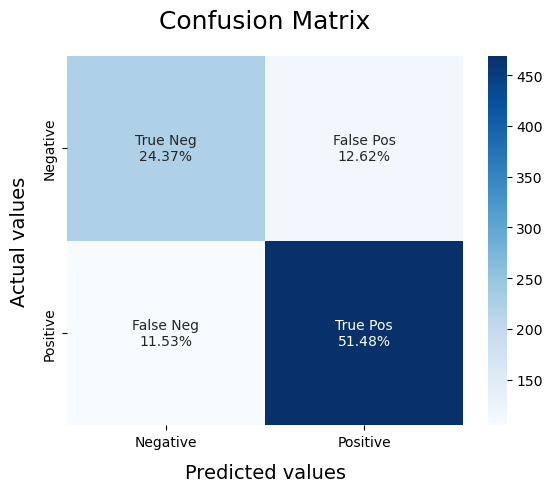

In [ ]:
classifier = BernoulliNB(alpha = 0.5)  # Tuning done on alpha -smoothing parameter - strength of regularization
classifier.fit(x_train_vector, y_train)
model_Evaluate(classifier)

### Logistic Regression with Balanced class weight

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.62      0.70      0.66       337
           1       0.81      0.75      0.78       574

    accuracy                           0.73       911
   macro avg       0.71      0.72      0.72       911
weighted avg       0.74      0.73      0.73       911



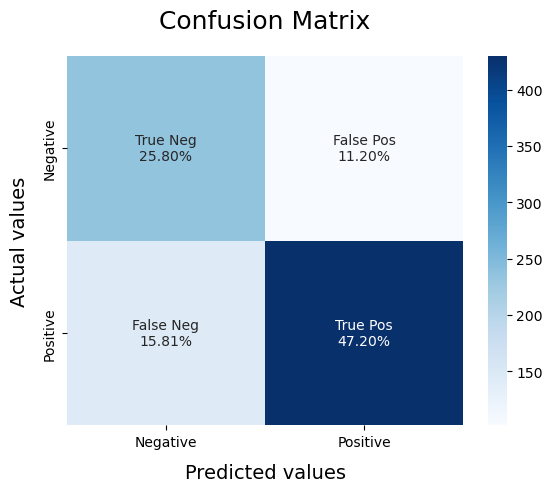

In [ ]:
classifier = LogisticRegression(class_weight='balanced')
classifier.fit(x_train_vector, y_train)
model_Evaluate(classifier)

### Logistic Regression with Custom class weight

              precision    recall  f1-score   support

           0       0.62      0.76      0.68       337
           1       0.84      0.72      0.78       574

    accuracy                           0.74       911
   macro avg       0.73      0.74      0.73       911
weighted avg       0.76      0.74      0.74       911



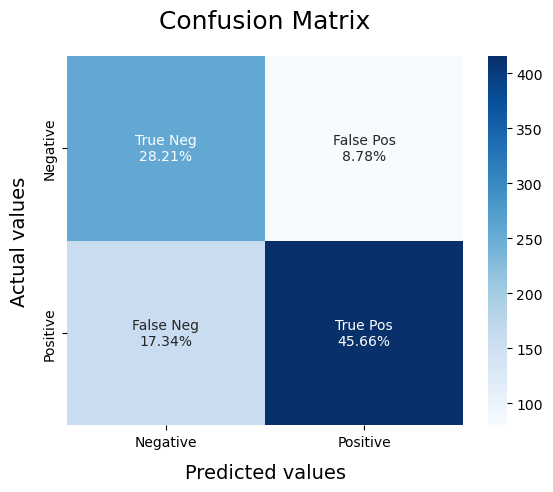

In [ ]:
classifier = LogisticRegression(C=0.3, class_weight={0: 1, 1:0.5}, max_iter=1000) # C is tuned -> inverse of the regularization strength
classifier.fit(x_train_vector, y_train)
model_Evaluate(classifier)

### Feature Extraction (Using TF-IDF)

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))
vectorizer.fit(x_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectorizer.get_feature_names()))

Vectoriser fitted.
No. of feature_words:  66658


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
x_train_vector = vectorizer.transform(x_train)
x_test_vector  = vectorizer.transform(x_test)
print(f'Data Transformed.')

Data Transformed.


### Bernoulli model

              precision    recall  f1-score   support

           0       0.67      0.62      0.64       337
           1       0.79      0.82      0.80       574

    accuracy                           0.75       911
   macro avg       0.73      0.72      0.72       911
weighted avg       0.74      0.75      0.74       911



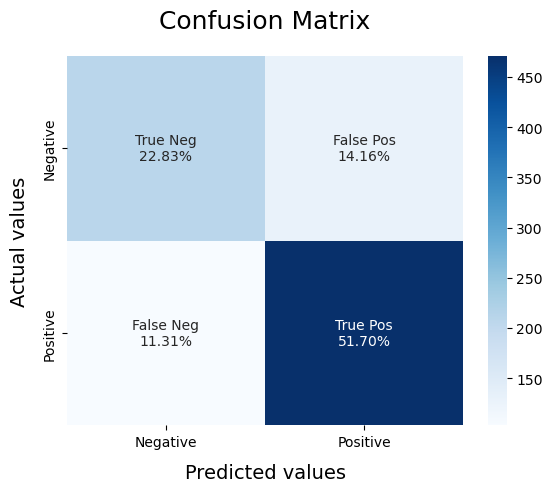

In [ ]:
classifier = BernoulliNB(alpha = 0.2)  # Tuning done on alpha -smoothing parameter - strength of regularization
classifier.fit(x_train_vector, y_train)
model_Evaluate(classifier)

### Linear SVC model

              precision    recall  f1-score   support

           0       0.71      0.53      0.61       337
           1       0.76      0.87      0.81       574

    accuracy                           0.75       911
   macro avg       0.74      0.70      0.71       911
weighted avg       0.74      0.75      0.74       911



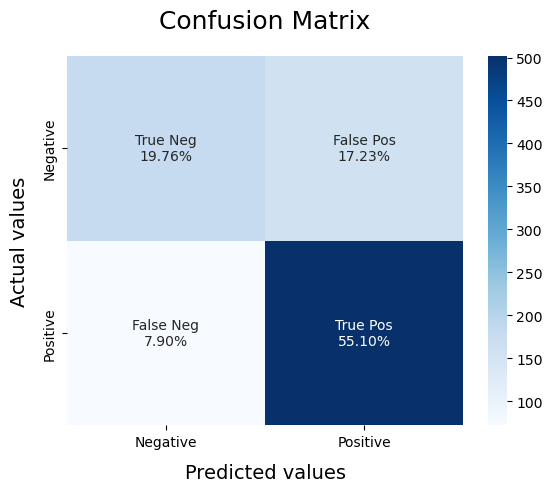

In [ ]:
classifier = LinearSVC()
classifier.fit(x_train_vector, y_train)
model_Evaluate(classifier)

### Logistic Regression Model

              precision    recall  f1-score   support

           0       0.72      0.51      0.60       337
           1       0.75      0.89      0.82       574

    accuracy                           0.75       911
   macro avg       0.74      0.70      0.71       911
weighted avg       0.74      0.75      0.73       911



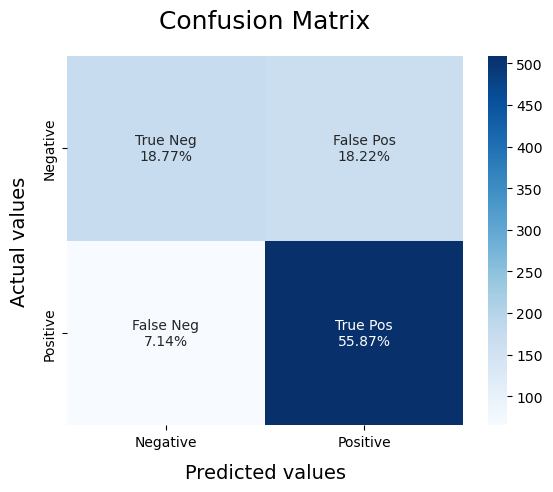

In [ ]:
classifier = LogisticRegression(C = 10, max_iter = 1000) # C is tuned -> inverse of the regularization strength
classifier.fit(x_train_vector, y_train)
model_Evaluate(classifier)

### Comparison Table

The comparison table shows the best scores achieved each trained model, after tuning the hyperparameters.

In [ ]:
df_compare = pd.read_csv('comparison_table.csv')

In [ ]:
df_compare

,Feature Extraction Method,ML Algorithm,Precision (0|1),F1-score (0|1),Accuracy
0,CountVectorization,Linear SVC,0.61|0.81,0.66|0.77,73%
1,CountVectorization,Bernoulli,0.68|0.80,0.67|0.81,76%
2,CountVectorization,Logistic Regression,0.62|0.84,0.68|0.78,74%
3,TF-IDF,Linear SVC,0.71|0.76,0.61|0.81,75%
4,TF-IDF,Bernoulli,0.67|0.79,0.64|0.80,75%
5,TF-IDF,Logistic Regression,0.72|0.75,0.60|0.82,75%


### Conclusion

We can see from the comparison table that all the models have nearly same Accuracy, Precision and F1-Score, with just minor differences. Based on overall score, we could consider Bernoulli with CountVectorization as the best model due to good precision value, better F1-score and the best accuracy. 

So we conclude that we can use any of these models to predict whether a tweet contains verifiable factual claims.  